<a href="https://colab.research.google.com/github/bgolshaei/Data_Science/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import pylab as pl
from pylab import *
import pandas as pd
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import cv2 as cv
import torch.utils.data as data_utils
import torch


# M3 Project
In first step, load the data and attach the position of pedestrian over the time to find out their trace.
## Data loading and preprocessing

In [3]:
from google.colab import files
uploaded = files.upload()

# To store dataset in a Pandas Dataframe
import io
df = pd.read_excel(io.BytesIO(uploaded['pixel_pos.xlsx']))
df

Saving pixel_pos.xlsx to pixel_pos.xlsx


,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,11,11.1,11.2,11.3,11.4,11.5,11.6,11.7,11.8,11.9,21,21.1,21.2,21.3,21.4,21.5,31,31.1,31.2,31.3,31.4,31.5,41,41.1,41.2,41.3,41.4,41.5,51,51.1,...,17971.1,17971.2,17971.3,17971.4,17971.5,17981,17981.1,17981.2,17981.3,17991,17991.1,17991.2,17991.3,18001,18001.1,18001.2,18011,18011.1,18011.2,18011.3,18021,18021.1,18021.2,18021.3,18031,18031.1,18031.2,18031.3,18041,18041.1,18041.2,18041.3,18051,18051.1,18051.2,18051.3,18061,18061.1,18061.2,18061.3
0,1.000000,2.000000,3.000000,4.000000,5.00000,6.00000,7.00000,8.00000,9.000000,10.000000,1.000000,2.000000,3.000000,4.000000,5.00000,6.00000,7.00000,8.00000,9.000000,10.000000,3.000000,4.000000,5.00000,6.00000,7.00000,8.00000,3.000000,4.000000,5.00000,6.00000,7.00000,8.00000,3.000000,4.000000,5.00000,6.00000,7.00000,8.00000,3.000000,4.000000,...,415.000000,416.000000,417.000000,418.000000,419.00000,416.000000,417.000000,418.000000,419.00000,416.000000,417.000000,418.000000,419.00000,416.000000,417.00000,419.00000,416.00000,417.000000,419.00000,420.00000,416.000000,417.000000,419.000000,420.00000,416.000000,417.00000,419.000000,420.00000,416.000000,417.000000,419.000000,420.00000,416.000000,417.00000,419.000000,420.00000,416.000000,417.000000,419.00000,420.00000
1,0.000537,-0.058169,0.057966,0.089990,-0.19839,-0.20743,-0.25568,-0.18920,-0.015058,-0.099742,-0.008186,-0.055556,0.033936,0.091405,-0.19839,-0.20743,-0.25485,-0.18920,-0.013632,-0.099664,0.006626,0.089075,-0.19839,-0.20743,-0.25435,-0.18920,-0.019004,0.089006,-0.19839,-0.20743,-0.25070,-0.18920,-0.038338,0.088161,-0.19839,-0.20743,-0.25379,-0.18920,-0.065713,0.081802,...,-0.012193,-0.001213,0.096278,0.169740,0.12924,-0.003432,0.085950,0.171790,0.12923,-0.008060,0.081550,0.169630,0.12921,-0.007582,0.07842,0.13039,-0.00842,0.072937,0.12687,0.14095,-0.011595,0.074639,0.126930,0.14191,-0.011192,0.07748,0.126990,0.14649,-0.015692,0.076763,0.125920,0.14752,-0.016237,0.08181,0.130800,0.14847,-0.017156,0.086995,0.13086,0.14831
2,-0.184570,-0.268610,-0.104790,0.036724,0.26015,0.28619,0.35023,0.14792,-0.375330,-0.461820,-0.229380,-0.312070,-0.073139,0.085140,0.26015,0.28619,0.36388,0.14792,-0.417130,-0.460460,-0.030256,0.131390,0.26015,0.28619,0.37207,0.14792,0.002037,0.174680,0.26015,0.28619,0.38798,0.14792,0.037810,0.225920,0.26015,0.28619,0.42569,0.14792,0.068049,0.264910,...,-0.368770,-0.014703,-0.025790,0.008712,-0.30743,-0.054509,-0.060171,0.047385,-0.26277,-0.092789,-0.096616,0.073598,-0.21814,-0.128960,-0.13194,-0.17366,-0.16637,-0.165780,-0.12746,-0.37913,-0.200940,-0.201650,-0.081621,-0.33849,-0.238530,-0.23893,-0.035823,-0.29685,-0.274440,-0.274610,0.011378,-0.25501,-0.306650,-0.31603,0.057797,-0.21453,-0.345600,-0.354760,0.10345,-0.17268


In [527]:
df.T.groupby(0).get_group(387)

,0,1,2
16441.10,387.0,-0.041272,-0.440050
16451.10,387.0,-0.040914,-0.388690
16461.10,387.0,-0.048025,-0.335550
16471.10,387.0,-0.046330,-0.282980
16481.10,387.0,-0.049970,-0.235460
16491.9,387.0,-0.054718,-0.185130
16501.9,387.0,-0.049322,-0.134380
16511.9,387.0,-0.048961,-0.083250
16521.8,387.0,-0.043581,-0.032721
16531.8,387.0,-0.040869,0.015309


In [12]:
df.T.groupby(0).size().sort_values()

0
314.0      1
1.0        2
2.0        2
178.0      2
202.0      2
        ... 
371.0     67
369.0     67
356.0     77
361.0     87
38.0     100
Length: 390, dtype: int64

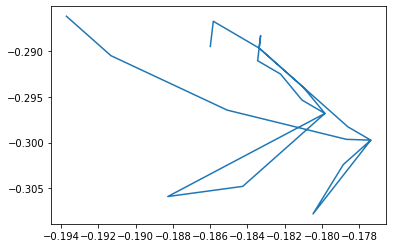

In [14]:
plt.plot(df.T.groupby(0).get_group(38)[1],df.T.groupby(0).get_group(38)[2])

In [6]:
sampl11=df.T.groupby(0).get_group(1)


for i in df.T.groupby(0).groups.keys():
  sampl11=pd.concat([sampl11,df.T.groupby(0).get_group(i).drop([0], axis=1)], axis=1,ignore_index=False)

data_clean=sampl11.fillna(0)
data_clean.loc[:, (data_clean==0).mean() < 6500]


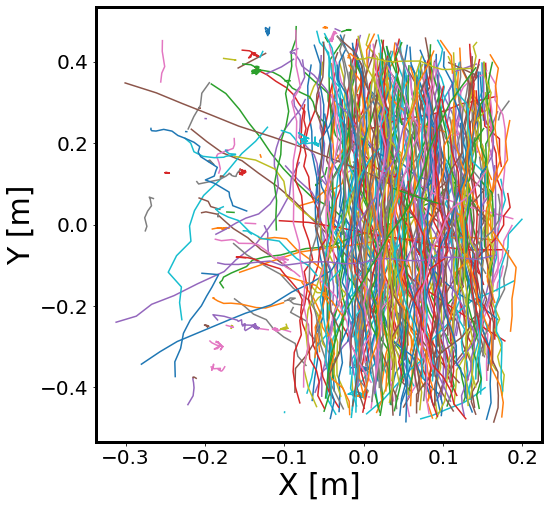

In [22]:
 for i in df.T.groupby(0).groups.keys():
   plt.plot(df.T.groupby(0).get_group(i)[1],df.T.groupby(0).get_group(i)[2])
plt.xlabel('X [m]',fontsize=30)
plt.ylabel('Y [m]',fontsize=30)
plt.rcParams['axes.linewidth'] = 8
plt.rcParams["figure.figsize"]=(8,8)
plt.rcParams.update({'font.size': 20})

In [55]:
data_clean=sampl11.fillna(0)
drop_data=data_clean.loc[:, (data_clean==0).mean() < 0.997]

In [62]:

x_train = df.T.groupby(0).get_group(38).iloc[:50, :][2].to_numpy()
x_test = df.T.groupby(0).get_group(38).iloc[50:100,:][2]
x_train

array([-0.28949, -0.28812, -0.28674, -0.28674, -0.28674, -0.28674,
       -0.28674, -0.28674, -0.28674, -0.28967, -0.29397, -0.29681,
       -0.29681, -0.29681, -0.29681, -0.29681, -0.29681, -0.29681,
       -0.29681, -0.29681, -0.29681, -0.30478, -0.30589, -0.29681,
       -0.29681, -0.29681, -0.29681, -0.29535, -0.29251, -0.29105,
       -0.2883 , -0.28967, -0.29397, -0.29827, -0.29973, -0.29973,
       -0.29973, -0.29973, -0.30779, -0.30239, -0.29973, -0.29973,
       -0.29973, -0.29973, -0.29973, -0.29973, -0.29973, -0.29973,
       -0.29973, -0.29973])

# Training of the netwrok

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [121]:


###### for prediction ############
series_t = torch.tensor(np.arange(len(x_train)))
print(series_t)
series_t = torch.unsqueeze(series_t, dim=1)
series_t = torch.unsqueeze(series_t, dim=1)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])


In [125]:
def trend(time, slope):
    return slope*time
def seasonality_pattern(season_time):
    return np.where(season_time <0.4, np.cos(2*np.pi*season_time), 1 / np.exp(3 * season_time))
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonality_pattern(season_time)
def noise(time, noise_level=1):
    return np.random.randn(len(time)) * noise_level
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5



In [510]:
split_time = 1
window_size = 20
batch_size = 10
input_dim = 1
hidden_dim = 40
out_dim = 1
num_layers = 40
num_dir = 2
num_epochs = 100
learning_rate = 0.001
rnn_module = "lstm"  #lsdm  

In [511]:
def Windowed_Dataset(series, window_size, stride, batch_size):
    """
    params:
        series: time series data
        window_size: K
        stride: stride between windows
        batch_size: batch size for training
    return:
        ds_loader: wrap windowed data into pytorch dataloader
    """
    f_s = window_size + 1
    l = len(series)
    ds = torch.from_numpy(series)
    ds = torch.unsqueeze(ds, dim=1)
    ds = [ds[i:i+f_s] for i in range(0, l, stride) if i <= l-f_s]
    #print(ds)
    ds_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=1)
    return ds_loader
train_loader = Windowed_Dataset(x_train, window_size=window_size, stride=1, batch_size=batch_size)
test_loader = Windowed_Dataset(x_test.to_numpy(), window_size=window_size, stride=1, batch_size=batch_size)

In [512]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, out_dim, batch_size, num_dir, rnn_module):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.out_dim = out_dim 
        self.bs = batch_size
        self.nd = num_dir
        
        if self.nd == 2:
            bidir = True
        else:
            bidir = False
        if rnn_module == "srnn":
            self.rnnmodule = nn.RNN(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=bidir)
        elif rnn_module == "lstm":
            self.rnnmodule = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=bidir)
        self.linear = nn.Linear(self.hidden_dim*self.nd, self.out_dim)
    
    def forward(self, x):
#         h0 = torch.zeros(self.num_layers, self.bs, self.hidden_dim).to(device)
        #print("hi1")
        #hidden = self._init_hidden(batch_size)

        out, _ = self.rnnmodule(x)
        
        out = self.linear(out[-1])
        out = out*100
        return out

In [513]:
model = RNN(input_dim, hidden_dim, num_layers, out_dim, batch_size, num_dir, rnn_module)
model = model.to(device)
criterion = nn.SmoothL1Loss() # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

RNN(
  (rnnmodule): LSTM(1, 40, num_layers=40, bidirectional=True)
  (linear): Linear(in_features=80, out_features=1, bias=True)
)


In [514]:
best_loss = 1e+100
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    running_test_loss = 0
    for batch_index, item in enumerate(train_loader):
        
        inputs = item[0:batch_size,0:-1]
        #print(inputs.size())
        #print(inputs)
        inputs = torch.transpose(inputs, 0, 1)
        inputs = inputs.float()
        inputs = inputs.to(device)
        #print(inputs)
        target = item[0:batch_size,-1:].squeeze(dim=1)
        target = target.float()
        target = target.to(device)
        
        optimizer.zero_grad()
        #print(inputs.size())
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()       
    with torch.no_grad():
        for batch_index, item in enumerate(test_loader):
            inputs_test = item[0:batch_size,0:-1]
            inputs_test = torch.transpose(inputs_test, 0, 1)
            inputs_test = inputs_test.float()
            inputs_test = inputs_test.to(device)
            target_test = item[0:batch_size,-1:].squeeze(dim=1)
            target_test = target_test.float()
            target_test = target_test.to(device)

            out_test = model(inputs_test)
            loss_test = criterion(out_test, target_test)
            running_test_loss += loss_test.item()
        if epoch%10 == 0:
            print('Epoch {} : Training loss is {:.4f} \
                '.format(epoch, running_train_loss/(batch_index+1)))
            print('Epoch {} : Test loss is {:.4f} \
                '.format(epoch, running_test_loss/(batch_index+1)))
        if best_loss > running_test_loss*batch_size/len(x_test):
            torch.save(model, 'ckpt_time_series.pth')
            best_loss = running_test_loss*batch_size/len(x_test)

Epoch 0 : Training loss is 0.9952                 
Epoch 0 : Test loss is 0.1753                 
Epoch 10 : Training loss is 0.0174                 
Epoch 10 : Test loss is 0.0008                 
Epoch 20 : Training loss is 0.0006                 
Epoch 20 : Test loss is 0.0011                 
Epoch 30 : Training loss is 0.0000                 
Epoch 30 : Test loss is 0.0002                 
Epoch 40 : Training loss is 0.0000                 
Epoch 40 : Test loss is 0.0000                 
Epoch 50 : Training loss is 0.0000                 
Epoch 50 : Test loss is 0.0000                 
Epoch 60 : Training loss is 0.0000                 
Epoch 60 : Test loss is 0.0000                 
Epoch 70 : Training loss is 0.0000                 
Epoch 70 : Test loss is 0.0001                 
Epoch 80 : Training loss is 0.0000                 
Epoch 80 : Test loss is 0.0000                 
Epoch 90 : Training loss is 0.0000                 
Epoch 90 : Test loss is 0.0001                 


In [515]:
def prediction(model_name, series, window_size):
    model = torch.load(model_name)
    model.eval()
    model = model.to(device)
    forcast = []
    for time_step in range(len(x_train) - window_size):
        Input_time = series_t[time_step:time_step+window_size,:,:]
        #print(Input_time)
        Input_time = Input_time.float()
        Input_time = Input_time.to(device)
        #print(model(Input_time))
        forcast.append(model(Input_time))
        #print(forcast.append(model(Input_time)))
    result = forcast[split_time-window_size:]
    result = [x.detach().cpu().numpy().squeeze() for x in result]
    return result

In [516]:
#srnn_result = prediction('SRNN_ckpt_time_series.pth', x_test, window_size)
lstm_result = prediction('ckpt_time_series.pth', x_test, window_size)
#lstm_result

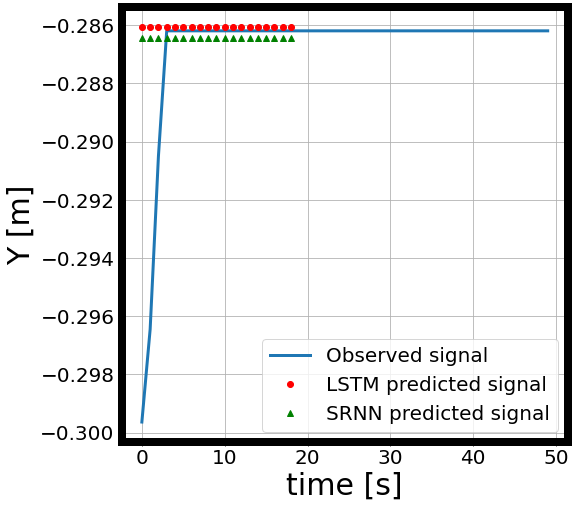

In [517]:
#plt.figure(figsize=(12, 7))
t=np.arange(len(x_train))
plt.plot(t, x_test, lw = 3)
plt.plot(t[0:len(lstm_result)],lstm_result ,'o', lw = 3, c = 'r')
plt.plot(t[0:len(srnn_result)],srnn_result ,'^', lw = 3, c = 'g')
plt.grid()
plt.legend(['Observed signal', 'LSTM predicted signal','SRNN predicted signal'])
plt.xlabel('time [s]',fontsize=30)
plt.ylabel('Y [m]',fontsize=30)
plt.rcParams['axes.linewidth'] = 8
plt.rcParams["figure.figsize"]=(8,8)
plt.rcParams.update({'font.size': 20})

In [539]:
First_ped=df.T.groupby(0).get_group(374)

for i in range(377,388):
  First_ped=pd.concat([First_ped,df.T.groupby(0).get_group(i).drop([0], axis=1)], axis=1,ignore_index=True)
  
data_clean=First_ped.fillna(0)

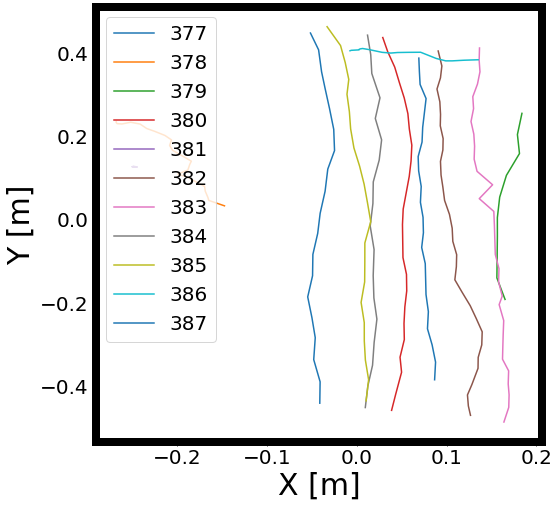

In [544]:
for i in range(377,388):
   plt.plot(df.T.groupby(0).get_group(i)[1],df.T.groupby(0).get_group(i)[2],label=str(i))
plt.xlabel('X [m]',fontsize=30)
plt.ylabel('Y [m]',fontsize=30)
plt.rcParams['axes.linewidth'] = 8
plt.rcParams["figure.figsize"]=(8,8)
plt.rcParams.update({'font.size': 20})
plt.legend()

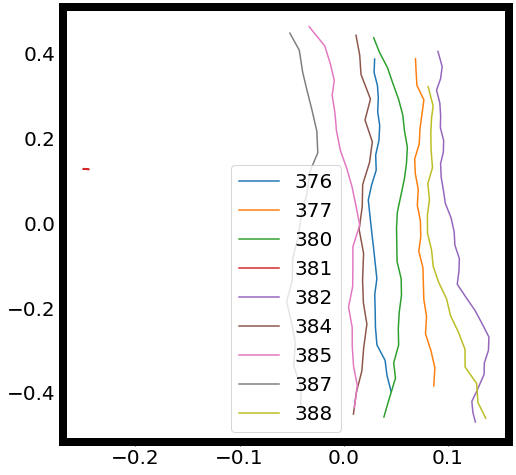

In [550]:
selected_data=[376,377,380,381,382,384,385,387,388]
for i in selected_data:
   plt.plot(df.T.groupby(0).get_group(i)[1],df.T.groupby(0).get_group(i)[2],label=str(i))
   plt.legend()

In [552]:

First_ped=df.T.groupby(0).get_group(376)

for i in selected_data:
  First_ped=pd.concat([First_ped,df.T.groupby(0).get_group(i).drop([0], axis=1)], axis=1,ignore_index=True)
  
data_clean=First_ped.fillna(0)
data_clean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
16161.15,376.0,0.029805,0.38667,0.029805,0.38667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
16171.15,376.0,0.029284,0.35510,0.029284,0.35510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
16181.15,376.0,0.032499,0.32422,0.032499,0.32422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
16191.15,376.0,0.033345,0.29505,0.033345,0.29505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
16201.15,376.0,0.032752,0.26213,0.032752,0.26213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16641.4,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084057,0.17277
16651.4,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083778,0.21217
16661.4,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084488,0.24745
16671.4,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086045,0.27602


In [553]:
x_train_g = data_clean.iloc[:97, :][2].to_numpy()
x_test_g = data_clean.iloc[97:194,:][2]
x_train_g

array([ 0.38667 ,  0.3551  ,  0.32422 ,  0.29505 ,  0.26213 ,  0.23013 ,
        0.19456 ,  0.16062 ,  0.1248  ,  0.089612,  0.054197,  0.016818,
       -0.020565, -0.056634, -0.094028, -0.13143 , -0.1685  , -0.20583 ,
       -0.24584 , -0.28728 , -0.32383 , -0.35861 , -0.39752 ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      , 

In [554]:
train_loader_g = Windowed_Dataset(x_train_g, window_size=window_size, stride=1, batch_size=batch_size)
test_loader_g = Windowed_Dataset(x_test_g.to_numpy(), window_size=window_size, stride=1, batch_size=batch_size)

In [556]:
best_loss = 1e+100
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0
    running_test_loss = 0
    for batch_index, item in enumerate(train_loader_g):
        
        inputs = item[0:batch_size,0:-1]
        #print(inputs.size())
        #print(inputs)
        inputs = torch.transpose(inputs, 0, 1)
        inputs = inputs.float()
        inputs = inputs.to(device)
        #print(inputs)
        target = item[0:batch_size,-1:].squeeze(dim=1)
        target = target.float()
        target = target.to(device)
        
        optimizer.zero_grad()
        #print(inputs.size())
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()       
    with torch.no_grad():
        for batch_index, item in enumerate(test_loader_g):
            inputs_test = item[0:batch_size,0:-1]
            inputs_test = torch.transpose(inputs_test, 0, 1)
            inputs_test = inputs_test.float()
            inputs_test = inputs_test.to(device)
            target_test = item[0:batch_size,-1:].squeeze(dim=1)
            target_test = target_test.float()
            target_test = target_test.to(device)

            out_test = model(inputs_test)
            loss_test = criterion(out_test, target_test)
            running_test_loss += loss_test.item()
        if epoch%10 == 0:
            print('Epoch {} : Training loss is {:.4f} \
                '.format(epoch, running_train_loss/(batch_index+1)))
            print('Epoch {} : Test loss is {:.4f} \
                '.format(epoch, running_test_loss/(batch_index+1)))
        if best_loss > running_test_loss*batch_size/len(x_test):
            torch.save(model, 'ckpt_time_series_g.pth')
            best_loss = running_test_loss*batch_size/len(x_test)

Epoch 0 : Training loss is 0.0121                 
Epoch 0 : Test loss is 0.0073                 
Epoch 10 : Training loss is 0.0093                 
Epoch 10 : Test loss is 0.0000                 
Epoch 20 : Training loss is 0.0068                 
Epoch 20 : Test loss is 0.0021                 


KeyboardInterrupt: ignored